In [1]:
import os
import tensorflow as tf
import keras
from keras import Sequential
from keras.models import Model
from keras.layers import *

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
INPUT_SHAPE = (256,256,3)

# DATA

### Loading the Datasets

In [6]:
!tar -zxvf {'archive.tar.gz'}

Data/train.tfrecord/
Data/train.tfrecord/1288161654912879604/
Data/train.tfrecord/1288161654912879604/00000000.shard/
Data/train.tfrecord/1288161654912879604/00000000.shard/00000000.snapshot
Data/train.tfrecord/dataset_spec.pb
Data/train.tfrecord/snapshot.metadata
Data/test.tfrecord/
Data/test.tfrecord/1115346842713590724/
Data/test.tfrecord/1115346842713590724/00000000.shard/
Data/test.tfrecord/1115346842713590724/00000000.shard/00000000.snapshot
Data/test.tfrecord/dataset_spec.pb
Data/test.tfrecord/snapshot.metadata


In [7]:
train = tf.data.Dataset.load('Data/train.tfrecord')
test = tf.data.Dataset.load('Data/test.tfrecord')

In [8]:
train, test

(<_LoadDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>,
 <_LoadDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>)

# MODEL

### Building the Model

In [15]:
class UNet(Model):
    def __init__(self):
        super(UNet, self).__init__()

        self.model = self.build_model()


    # Builds the model
    def build_model(self):
        # Builds the convolutional blocks
        def double_conv(kernel, inputs):
            x = Conv2D(kernel, 3, activation='relu', padding='same', kernel_initializer = "he_normal")(inputs)
            return Conv2D(kernel, 3, activation='relu', padding='same', kernel_initializer = "he_normal")(x)


        # U-Net
        input = Input(shape=INPUT_SHAPE)

        # Encoder part
        x = double_conv(64, input)
        y = MaxPooling2D(2)(x)

        y = double_conv(128, y)
        z = MaxPooling2D(2)(y)

        z = double_conv(256, z)
        v = MaxPooling2D(2)(z)

        v = double_conv(512, v)
        f = MaxPooling2D(2)(v)

        f = double_conv(1024, f)
        # Decoder part
        f = Conv2DTranspose(512, 3, 2, padding='same')(f)
        f = Concatenate()([v,f])
        f = double_conv(512, f)

        f = Conv2DTranspose(256, 3, 2, padding='same')(f)
        f = Concatenate()([z,f])
        f = double_conv(256, f)

        f = Conv2DTranspose(128, 3, 2, padding='same')(f)
        f = Concatenate()([y,f])
        f = double_conv(128, f)

        f = Conv2DTranspose(64, 3, 2, padding='same')(f)
        f = Concatenate()([x,f])
        f = double_conv(64, f)

        out = Conv2D(1, 1, padding="same", activation='sigmoid')(f)

        return Model(inputs=input, outputs=out)


    def save(self, file_path):
        self.model.save(file_path)


    def call(self, inputs):
        return self.model(inputs)

In [16]:
model = UNet()

### Loss Function

In [17]:
def dice_loss_func(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1 -(2.0 * intersection + 1) / (union + 1)

def loss_func(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice_loss = dice_loss_func(y_true, y_pred)
    return binary_cross_entropy_loss + 3*dice_loss

In [18]:
model.compile(optimizer='adam', loss=loss_func, metrics=['accuracy'])

### Training the Model

In [ ]:
model.fit(train, epochs=40, validation_data=test)

### Testing the Model

In [20]:
sample = test.as_numpy_iterator().next()

##### Original image and original mask

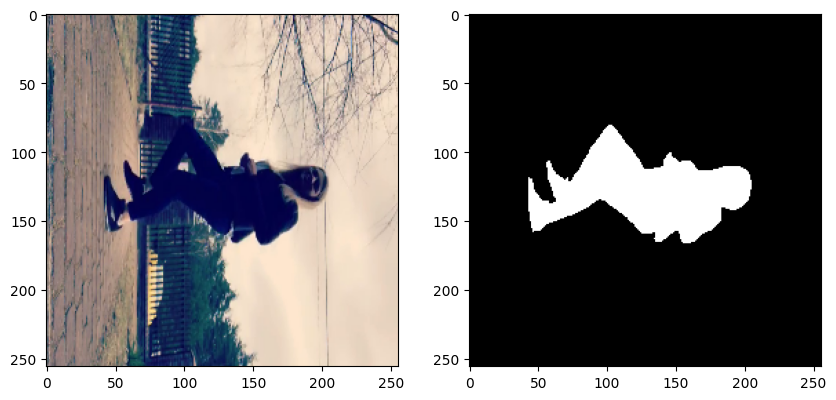

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(tf.cast(sample[0][-1]*255, dtype=tf.uint8))
ax[1].imshow(tf.cast(sample[1][-1], dtype=tf.uint8), cmap='gray')

##### Model's output mask

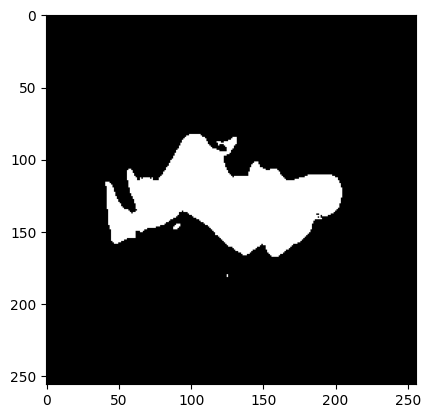

In [22]:
mask = model(sample[0])

mask = np.where(mask > 0.2, 1, mask)
mask = np.where(mask < 0.2, 0, mask)

plt.imshow(mask[-1], cmap='gray')

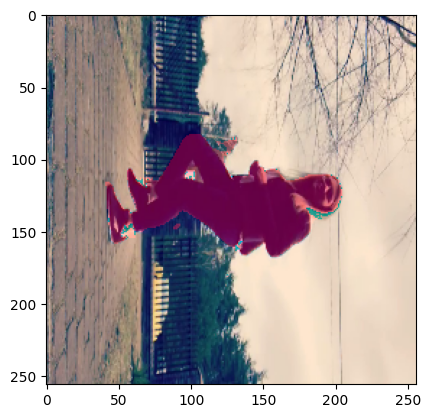

In [23]:
new = sample[0][-1].copy()*255
density = 100
for row in range(new.shape[0]):
    for col in range(new.shape[1]):
        if mask[-1][row][col] == 1 :
            if new[row][col][0] < 205:
                new[row][col][0] += density
            else:
                new[row][col][0] = 255

plt.imshow(tf.cast(new, dtype=tf.uint8))

### Saving the Model

In [ ]:
model.save('U-NET.h5')